In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

# Empty Class

What adversarial samples do we get if we start with an empty class?

## Simple GP Classification

In [2]:
#build model
from GPadversarial import simple
m = simple.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0004   1.885035e+02   3.931021e-01 
    01s20  0025   2.142309e+01   1.840610e-05 
    01s75  0035   2.133011e+01   2.556945e-13 
Runtime:     01s75
Optimization status: Converged



Crossed boundary after 2 changes


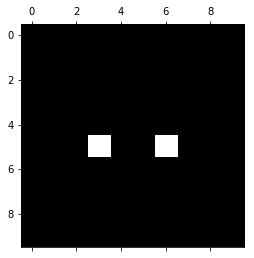

In [3]:
advX = np.zeros_like(testX[1:2,:]) #the initial test point we're going to use...
advsample, pred, N = simple.generate_adversarial_example(m, advX, changedir=+1)
if advsample is not None:
    print("Crossed boundary after %d changes" % N)
    plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
else:
    print("Failed to find adversarial example")

## GPLVM

In [5]:
from GPadversarial import lvm
m, clf = lvm.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s13  005   4.048738e+06   5.122574e+11 
    00s18  008   1.603485e+06   1.604464e+10 
    01s68  102   1.385180e+05   4.790781e+02 
Runtime:     01s68
Optimization status: Maximum number of f evaluations reached



 /home/mike/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


[[ 19.2251437]] [[-0.21877836]]


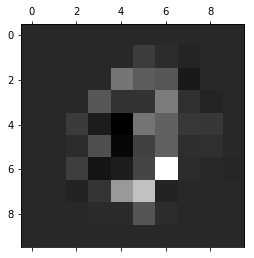

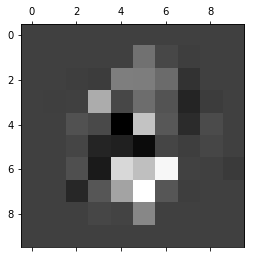

In [6]:
advX = np.zeros_like(testX[0:1,:])
advsample, intermediatesample = lvm.generate_adversarial_example_near_boundary(m,clf,advX)
plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
plt.matshow(intermediatesample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [7]:
print(lvm.get_pred(m,clf,advX))
print(lvm.get_pred(m,clf,intermediatesample))
print(lvm.get_pred(m,clf,advsample))

[[ 19.2251437]]
[[-0.69470603]]
[[-12.06422319]]


The earlier pair of scores is for the seed point, and the point just after one has crossed the boundary: In my run it goes from -38 to +4. I found that searching along the boundary can lead to the actual value becoming further from 0; but, presumably the pixels get closer.